In [21]:
import fitz
import cv2
import numpy as np
import re
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
import keras_ocr
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import csv
import joblib








In [22]:
# my_work
import re


class Data:
    def __init__(self,tex_file,pdf):
        self.bold_words = []
        self.italic_words = []
        self.underline_words = []
        self.normal_words= []
        self.font_size=None
        self.texfile=tex_file
        self.pdf=pdf
        self.image_paths=[]
        self.features_array=None
        self.labels_array=None

    def extract_from_tex(self):
        with open(self.texfile, 'r') as f:
          tex_content = f.read()

        # Define regular expression patterns to match LaTeX commands and formatting annotations
        command_pattern = r'\\(?:documentclass|usepackage|begin|fontsize|vspace|selectfont|end){.*?}|{.*?}\\selectfont'
        bold_pattern = r'\\textbf{([^}]*)}'
        italic_pattern = r'\\textit{([^}]*)}'
        underline_pattern = r'\\uline{([^}]*)}'
        font_size_pattern = r'\\fontsize{(\d+)}'

        # Find all occurrences of formatting annotations and LaTeX commands
        commands = re.findall(command_pattern, tex_content, flags=re.DOTALL)
        bold_matches = re.findall(bold_pattern, tex_content, flags=re.DOTALL)
        italic_matches = re.findall(italic_pattern, tex_content, flags=re.DOTALL)
        underline_matches = re.findall(underline_pattern, tex_content, flags=re.DOTALL)
        size_match = re.search(font_size_pattern, tex_content)


        font_size = int(size_match.group(1))  # Extract the font size
        print("Font size:", font_size)
        self.font_size=font_size
       

        # Remove LaTeX commands from the text content
        for command in commands:
            tex_content = tex_content.replace(command, '')

        # Extract text content from LaTeX file
        text_content = re.findall(r'{(.*?)}', tex_content, flags=re.DOTALL)

        bold_set = set(bold_matches)
        italic_set = set(italic_matches)
        underline_set = set(underline_matches)

        # Find the left-out parts (normal matches)
        normal_matches = []

        for content in text_content:
            if content not in bold_set and content not in italic_set and content not in underline_set:
                normal_matches.append(content)

        words_with_format = []

        words_with_format += [(match, 'bold') for match in bold_matches]
        words_with_format += [(match, 'italic') for match in italic_matches]
        words_with_format += [(match, 'underline') for match in underline_matches]
        words_with_format += [(match, 'normal') for match in normal_matches]


        word_count = {}

        # Count occurrences of words across all font styles
        for words, _ in words_with_format:
            words = words.split()
            for word in words:
                word_count[word] = word_count.get(word, 0) + 1

        filtered_output = []
        # print(word_count)

        # Filter words that occur only once in the entire dataset
        for words, font_style in words_with_format:
            words = words.split()
            filtered_words = [word for word in words if word_count[word] == 1]
            filtered_output.append((' '.join(filtered_words), font_style))

        for text, style in filtered_output:
            print(text)
            if style == 'bold':
                self.bold_words.append(text)
            elif style == 'italic':
                self.italic_words.append(text)
            elif style == 'underline':
                self.underline_words.append(text)
            elif style == 'normal':
                self.normal_words.append(text)

    def convert_to_img(self):
        # Path to your PDF file
        pdf_path = self.pdf

        # Extract the PDF file name without extension
        pdf_name = os.path.splitext(os.path.basename(pdf_path))[0]

        # Open the PDF file
        pdf_document = fitz.open(pdf_path)

        # Iterate through each page in the PDF
        for page_number in range(len(pdf_document)):
            # Get the page
            page = pdf_document.load_page(page_number)

            # Convert the page to an image
            pix = page.get_pixmap()

            # Save the image with PDF file name added
            image_path = f'{pdf_name}_page_{page_number + 1}.png'
            pix.save(image_path)
            self.image_paths.append(image_path)

        # Close the PDF document
        pdf_document.close()


    def features_data(self):
        model = VGG16(weights='imagenet', include_top=False)
        print("model passed")

        # Initialize the OCR pipeline
        pipeline = keras_ocr.pipeline.Pipeline()

        labels_list = []
        features_list = []
 

        # Read the image
        for i in range(len(self.image_paths)):
            img_path = self.image_paths[i]
            image = keras_ocr.tools.read(img_path)
            print("image")
            if isinstance(image, list) and len(image) > 0:
                image = image[0]  # Assuming the first element is the image data


            # Perform OCR recognition
            prediction_groups = pipeline.recognize([image])
            print('prediction_groups')
            

            # print(f"bold {self.bold_words}")
            # print(f"italic {self.italic_words}")
            # print(f"underline {self.underline_words}")
            # print(f"normal {self.normal_words}")
            # b_words=self.bold_words[0].split()
            if self.bold_words:
                b_words = self.bold_words[0].split()
            else:
                b_words = []
            
            if self.italic_words:
                i_words = self.italic_words[0].split()
            else:   
                i_words = []

            if self.underline_words:
                u_words = self.underline_words[0].split()
            else:
                u_words = []

            if self.normal_words:
                n_words = self.normal_words[0].split()
            else:   
                n_words = []

            # print(b_words)
            # print(i_words)
            # print(u_words)
            # print(n_words)
            # Iterate through each prediction group (usually just one image)
            for predictions in prediction_groups:
                # Extract and save each bounding box as a separate image
                # predictions.sort(key=lambda x: x[1][1])
                for word, box in predictions:
                    # If the word occurred only once and is in either bold_words, italic_words, underline_words, or normal_words
                    pdf_unique=False

                    if word in b_words:
                        label = 'bold'
                        pdf_unique=True

                    elif word in i_words:
                        label = 'italic'
                        pdf_unique=True

                    elif word in u_words:
                        label = 'underline'
                        pdf_unique=True

                    elif word in n_words:
                        label='normal'
                        pdf_unique=True


                    if(pdf_unique):
                        # Convert box coordinates to integers
                        box = np.array(box, dtype=np.int32)

                        box[2][1] += 3

                        # Extract region of interest (ROI) from the image
                        x_min, y_min = int(np.min(box[:, 0])), int(np.min(box[:, 1]))
                        x_max, y_max = int(np.max(box[:, 0])), int(np.max(box[:, 1]))

                        # Ensure that the bounding box coordinates are within the image boundaries
                        x_min = max(0, x_min)
                        y_min = max(0, y_min)
                        x_max = min(image.shape[1], x_max)
                        y_max = min(image.shape[0], y_max)

                        roi = image[y_min:y_max, x_min:x_max]

                        # Preprocess the ROI image for VGG16 model
                        roi_resized = cv2.resize(roi, (224, 224))  # Resize to match VGG16 input size
                        roi_resized = np.expand_dims(roi_resized, axis=0)  # Add batch dimension
                        roi_preprocessed = preprocess_input(roi_resized)  # Preprocess input for VGG16

                        # Extract features using VGG16 model
                        features = model.predict(roi_preprocessed)
                        # Assign label based on word style
                        # print(word)
                        # print(label)
                        # Store features, labels, and bounding boxes

                        features_list.append(features)
                        labels_list.append([label,self.font_size])

        self.labels_array = np.array(labels_list)
        self.features_array=np.array(features_list)



In [23]:
import random
from collections import defaultdict


pdf_folder = 'dcmahi/pdf'
tex_folder = 'dcmahi/scripts'
# pdf_folder='aditya_pdf_df'
# tex_folder='aditya_tex_df'

# output_images_folder = 'output_images'

pdf_features = defaultdict(list)
pdf_labels = defaultdict(list)
pdf_counter=0


for pdf_file in os.listdir(pdf_folder):
    pdf_path = os.path.join(pdf_folder, pdf_file)

    # Extract corresponding LaTeX file name
    tex_file = os.path.join(tex_folder, os.path.splitext(pdf_file)[0] + '.tex')

    # Check if the LaTeX file exists

    
    # Increment the counter
    pdf_counter += 1

    # Break if we have processed 50 PDFs
    if pdf_counter > 5:
        break

    print(f"Processed PDF file: {pdf_path}")
    print(f"the tex file is {tex_file}")

    try:

        # Open the PDF file
        # pdf_document = fitz.open(pdf_path)

        data = Data(tex_file,pdf_path)
        data.extract_from_tex()
        data.convert_to_img()
        data.features_data()
        # print(data.bold_words)
        # print(data.italic_words)
        # print(data.underline_words)


        pdf_features[pdf_file].extend(data.features_array)
        pdf_labels[pdf_file].extend(data.labels_array)


    except Exception as e:
            print(f"Error processing PDF file '{pdf_file}': {e}")
            break
            # continue


Processed PDF file: dcmahi/pdf/5510.pdf
the tex file is dcmahi/scripts/5510.tex
Font size: 18
vervets bluegums mocked zoophilite axial-flow diddle-dee humourize Exira godless nonent nondistortion Lyerly recitativo boutefeu duckery satanically alidad unnauseated Gadus columnized circuited
hyposulfite Dentirostres quoties chay nonvisibility self-unloading cliquedom Margetts septics zygomorphic dichotomies cloacaline unlocomotive Aret breakpoint's jerkins anointed spiritmonger biforine multiinfection Reformationism gardeny saccadge prolegomenon eaten-leaf
pasticcios rallycross chirimoyer bromochloromethane oblongish Heligoland subpenaed uncaricatured scarrier pharyngopleural musculo- felinities outbribed trolly cuckooflower pieceless prediligently Rh-negative craniom etherealization commandatory tobaccomen pomaceous arthemis quoining whereup MLW uncicatrized Moustierian true-felt
model passed
Looking for /home/adi_techbuddy/.keras-ocr/craft_mlt_25k.h5
Looking for /home/adi_techbuddy/.kera

In [24]:
X_train = []
X_test = []
y_train = []
y_test = []

# # Iterate through PDFs to split data into training and testing sets
for pdf_file, features in pdf_features.items():
    labels = pdf_labels[pdf_file]

    # # Shuffle the data
    combined = list(zip(features, labels))
    random.shuffle(combined)
    features_shuffled, labels_shuffled = zip(*combined)

    # Split the data into training and testing sets
    split_index = int(len(features_shuffled) * 0.8)  # 80% for training, 20% for testing
    X_train.extend(features_shuffled[:split_index])
    X_test.extend(features_shuffled[split_index:])
    y_train.extend(labels_shuffled[:split_index])
    y_test.extend(labels_shuffled[split_index:])



In [25]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [26]:
y_train.shape

(204, 2)

In [27]:
y_train[0]

array(['underline', '18'], dtype='<U21')

In [28]:
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

Random Forest Classifier Accuracy: 0.8888888888888888
Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

        bold       0.80      0.94      0.86        17
      italic       0.86      0.92      0.89        13
   underline       1.00      0.83      0.91        24

    accuracy                           0.89        54
   macro avg       0.89      0.90      0.89        54
weighted avg       0.90      0.89      0.89        54



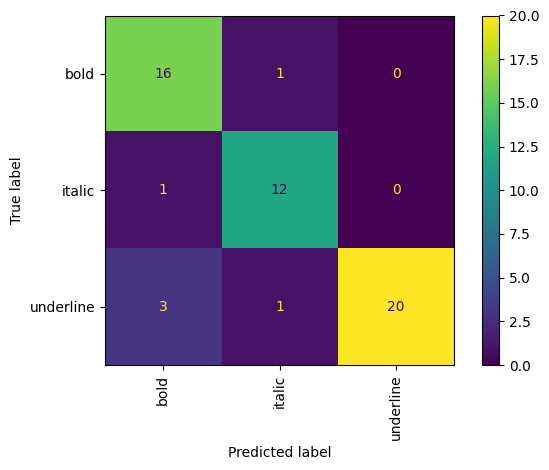

In [29]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train_flattened, y_train[:,0])

# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test_flattened)

# Evaluate the Random Forest classifier
accuracy_rf = accuracy_score(y_test[:,0], y_pred_rf)
classification_rep_rf = classification_report(y_test[:,0], y_pred_rf)

print(f"Random Forest Classifier Accuracy: {accuracy_rf}")
print("Random Forest Classifier Classification Report:")
print(classification_rep_rf)
ConfusionMatrixDisplay.from_estimator(
    rf_classifier,X_test_flattened, y_test[:,0], xticks_rotation="vertical")
plt.tight_layout()
plt.show()





# # Initialize the SVM classifier


Random Forest Classifier Accuracy: 1.0
Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

        bold       1.00      1.00      1.00        61
      italic       1.00      1.00      1.00        67
   underline       1.00      1.00      1.00        76

    accuracy                           1.00       204
   macro avg       1.00      1.00      1.00       204
weighted avg       1.00      1.00      1.00       204



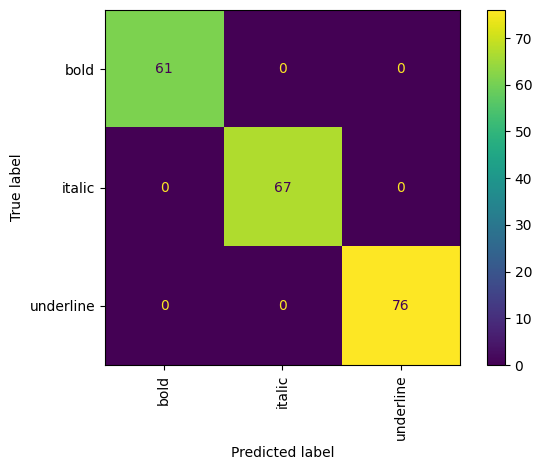

In [30]:

# Make predictions on the test set
y_trainpred_rf = rf_classifier.predict(X_train_flattened)

# Evaluate the Random Forest classifier
accuracy_rf = accuracy_score(y_train[:,0], y_trainpred_rf)
classification_rep_rf = classification_report(y_train[:,0], y_trainpred_rf)

print(f"Random Forest Classifier Accuracy: {accuracy_rf}")
print("Random Forest Classifier Classification Report:")
print(classification_rep_rf)
ConfusionMatrixDisplay.from_estimator(
    rf_classifier,X_train_flattened, y_train[:,0], xticks_rotation="vertical")
plt.tight_layout()
plt.show()





# # Initialize the SVM classifier


In [31]:
import joblib

# Save the trained Random Forest classifier model
joblib.dump(rf_classifier, 'rf_5.joblib')

['rf_5.joblib']

SVM Accuracy: 0.9629629629629629
SVM Classification Report:
              precision    recall  f1-score   support

        bold       1.00      0.88      0.94        17
      italic       0.87      1.00      0.93        13
   underline       1.00      1.00      1.00        24

    accuracy                           0.96        54
   macro avg       0.96      0.96      0.96        54
weighted avg       0.97      0.96      0.96        54



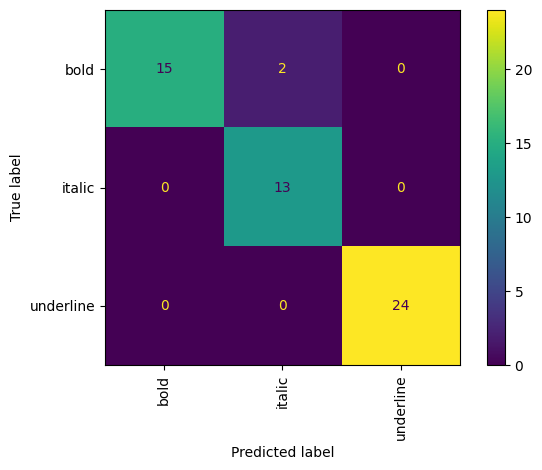

In [32]:
svm_classifier = SVC(kernel='linear', C=12.0, random_state=42)

# Train the classifier
svm_classifier.fit(X_train_flattened, y_train[:,0])

# Make predictions on the test set
y_pred_svm = svm_classifier.predict(X_test_flattened)

# Evaluate the SVM classifier
accuracy_svm = accuracy_score(y_test[:,0], y_pred_svm)
classification_rep_svm = classification_report(y_test[:,0], y_pred_svm)

print(f"SVM Accuracy: {accuracy_svm}")
print("SVM Classification Report:")
print(classification_rep_svm)
ConfusionMatrixDisplay.from_estimator(
    svm_classifier,X_test_flattened, y_test[:,0], xticks_rotation="vertical")
plt.tight_layout()
plt.show()

In [33]:
# # Save the trained SVM classifier model
joblib.dump(svm_classifier, 'svm_5.joblib')

['svm_5.joblib']

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Reshape X_train and X_test
X_train_reshaped = X_train_flattened.reshape((-1, 112, 224, 1))  # Assuming your image size is 112x224 with 1 channel
X_test_reshaped = X_test_flattened.reshape((-1, 112, 224, 1))

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(112, 224, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Output layer with 1 neuron for regression
])

y_train_int = y_train[:,1].astype(int)
y_test_int = y_test[:,1].astype(int)



# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # Mean Squared Error loss for regression

# Train the model
model.fit(X_train_reshaped, y_train_int, epochs=10, batch_size=50, validation_data=(X_test_reshaped, y_test_int))

Epoch 1/10
5/5 [==============================] - 5s 763ms/step - loss: 5251.4727 - mae: 49.8648 - val_loss: 512.7921 - val_mae: 22.3782
Epoch 2/10
5/5 [==============================] - 4s 726ms/step - loss: 400.5242 - mae: 19.6333 - val_loss: 219.2263 - val_mae: 14.4021
Epoch 3/10
5/5 [==============================] - 4s 731ms/step - loss: 153.5461 - mae: 11.7560 - val_loss: 41.6276 - val_mae: 5.3703
Epoch 4/10
5/5 [==============================] - 4s 693ms/step - loss: 20.2814 - mae: 3.5998 - val_loss: 55.5797 - val_mae: 6.1274
Epoch 5/10
5/5 [==============================] - 4s 676ms/step - loss: 40.4460 - mae: 5.3530 - val_loss: 21.1026 - val_mae: 3.6548
Epoch 6/10
5/5 [==============================] - 3s 661ms/step - loss: 25.2026 - mae: 4.1144 - val_loss: 38.0224 - val_mae: 5.0986
Epoch 7/10
5/5 [==============================] - 3s 655ms/step - loss: 19.5197 - mae: 3.6050 - val_loss: 18.8142 - val_mae: 3.6292
Epoch 8/10
5/5 [==============================] - 3s 651ms/step -

In [35]:
model.save("5_model.h5")

/home/adi_techbuddy/anaconda3/envs/mycondaenv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<h1>Testing

In [16]:


class Test_Data:
    def __init__(self,pdf=None):
        self.pdf = pdf
        self.image_path = None
        self.features_array = None
        self.words_list=[]
        

   

        
    def convert_to_img(self):
        # Path to your PDF file
        pdf_path = self.pdf

        # Extract the PDF file name without extension
        pdf_name = os.path.splitext(os.path.basename(pdf_path))[0]

        # Open the PDF file
        pdf_document = fitz.open(pdf_path)

        # Iterate through each page in the PDF
        for page_number in range(len(pdf_document)):
            # Get the page
            page = pdf_document.load_page(page_number)

            # Convert the page to an image
            pix = page.get_pixmap()

            # Save the image with PDF file name added
            image_path = f'{pdf_name}_page_{page_number + 1}.png'
            pix.save(image_path)
            self.image_path = image_path

        # Close the PDF document
        pdf_document.close()




    def features_data(self):
        model = VGG16(weights='imagenet', include_top=False)

        # Initialize the OCR pipeline
        pipeline = keras_ocr.pipeline.Pipeline()
    
        # Read the image
        img_path = self.image_path
        image = keras_ocr.tools.read(img_path)

        if isinstance(image, list) and len(image) > 0:
            image = image[0]  # Assuming the first element is the image data

        # Perform OCR recognition
        prediction_groups = pipeline.recognize([image])

        # labels_list = []
        features_list = []

        # Extract font size from the LaTeX file
        

        
        for predictions in prediction_groups:
            for word, box in predictions:
                # Convert box coordinates to integers
                box = np.array(box, dtype=np.int32)

                # Extract region of interest (ROI) from the image
                x_min, y_min = int(np.min(box[:, 0])), int(np.min(box[:, 1]))
                x_max, y_max = int(np.max(box[:, 0])), int(np.max(box[:, 1]))

                # Ensure that the bounding box coordinates are within the image boundaries
                x_min = max(0, x_min)
                y_min = max(0, y_min)
                x_max = min(image.shape[1], x_max)
                y_max = min(image.shape[0], y_max)

                roi = image[y_min:y_max, x_min:x_max]

                # Preprocess the ROI image for VGG16 model
                roi_resized = cv2.resize(roi, (224, 224))  # Resize to match VGG16 input size
                roi_resized = np.expand_dims(roi_resized, axis=0)  # Add batch dimension
                roi_preprocessed = preprocess_input(roi_resized)  # Preprocess input for VGG16

                # Extract features using VGG16 model
                features = model.predict(roi_preprocessed)

                # Store features and labels
                # features_list.append(features)
                features_list.append((word, features))


        # self.features_array = np.array(features_list)
        self.features_array = np.array([f[1] for f in features_list])  # Extract only features for array
        self.words_list = [f[0] for f in features_list]  # Extract words for list


In [17]:
def predict_font_size(pdf_path):
    # Initialize a Data instance
    data = Test_Data(pdf=pdf_path)

    # Extract font size from the PDF
    data.convert_to_img()
    data.features_data()

    # Preprocess the features
    features = data.features_array
    features_flattened = features.reshape(features.shape[0], -1)
    features_reshaped = features_flattened.reshape((-1, 112, 224, 1))

    # Predict font size
    predicted_font_sizes = model.predict(features_reshaped)
    # Get the list of words corresponding to the features
    words_list = data.words_list

    return predicted_font_sizes, words_list

In [18]:
# Assuming you have already trained and saved the model


pdf_path='aditya_pdf/25012.pdf'



# Example usage:
predicted_sizes, words = predict_font_size(pdf_path)
for i in range(len(predicted_sizes)):
    print("Word:", words[i], "\tPredicted Font Size:", predicted_sizes[i])


# Calculate the average font size
average_font_size = np.mean(predicted_sizes)

print("Average Predicted Font Size:", average_font_size)



Looking for /home/adi_techbuddy/.keras-ocr/craft_mlt_25k.h5
Looking for /home/adi_techbuddy/.keras-ocr/crnn_kurapan.h5
3/3 [==============================] - 0s 79ms/step
Word: daikon 	Predicted Font Size: [21.719093]
Word: quinoa 	Predicted Font Size: [18.563644]
Word: bean 	Predicted Font Size: [20.82817]
Word: bean 	Predicted Font Size: [22.679203]
Word: wild 	Predicted Font Size: [18.524002]
Word: thyme 	Predicted Font Size: [21.296526]
Word: sprout 	Predicted Font Size: [21.29048]
Word: sprout 	Predicted Font Size: [21.746635]
Word: bean 	Predicted Font Size: [22.642197]
Word: brussels 	Predicted Font Size: [21.131855]
Word: barley 	Predicted Font Size: [21.354263]
Word: chive 	Predicted Font Size: [21.984228]
Word: bean 	Predicted Font Size: [20.747759]
Word: salak 	Predicted Font Size: [20.697632]
Word: caraway 	Predicted Font Size: [19.576153]
Word: penny 	Predicted Font Size: [20.895222]
Word: quinoa 	Predicted Font Size: [20.398542]
Word: royal 	Predicted Font Size: [20.07362

In [19]:
# Assuming you have already trained and saved the model

# Load the trained model
# model = tf.keras.models.load_model('/Users/sudheer/Desktop/DESIGN CREDIT/FONTSIZE_PRED_1.h5')
pdf_path='aditya_pdf/25014.pdf'


# Example usage:
predicted_sizes,words = predict_font_size(pdf_path)
for i in range(len(predicted_sizes)):
    print("Word:", words[i], "\tPredicted Font Size:", predicted_sizes[i])  


Looking for /home/adi_techbuddy/.keras-ocr/craft_mlt_25k.h5
Looking for /home/adi_techbuddy/.keras-ocr/crnn_kurapan.h5
3/3 [==============================] - 0s 73ms/step
Word: broad 	Predicted Font Size: [20.9581]
Word: kumquat 	Predicted Font Size: [21.442333]
Word: chive 	Predicted Font Size: [22.160536]
Word: rice 	Predicted Font Size: [19.51602]
Word: freesia 	Predicted Font Size: [20.761171]
Word: violet 	Predicted Font Size: [22.222101]
Word: cashew 	Predicted Font Size: [19.31669]
Word: rasp 	Predicted Font Size: [20.507454]
Word: berry 	Predicted Font Size: [20.48608]
Word: walnut 	Predicted Font Size: [22.032148]
Word: loquat 	Predicted Font Size: [21.37822]
Word: mizuna 	Predicted Font Size: [18.818705]
Word: galangal 	Predicted Font Size: [21.368332]
Word: sprout 	Predicted Font Size: [22.104027]
Word: sprout 	Predicted Font Size: [21.209013]
Word: mung 	Predicted Font Size: [22.367077]
Word: calendula 	Predicted Font Size: [21.034386]
Word: lemon 	Predicted Font Size: [21.

In [20]:
# Calculate the average font size
average_font_size = np.mean(predicted_sizes)

print("Average Predicted Font Size:", average_font_size)

Average Predicted Font Size: 21.516376
